**Rozdział 14. Głębokie widzenie komputerowe za pomocą splotowych sieci neuronowych**

_Notatnik ten zawiera przykładowy kod i rozwiązania ćwiczeń opisane w rozdziale 14._

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/14_deep_computer_vision_with_cnns.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Uruchom w Google Colab (wersja angielska)</a>
  </td>
</table>

# Konfiguracja

Importujmy najpierw kilka popularnych modułów, upewnijmy się, że będą wstawiane wykresy MatplotLib, a także przygotujmy funkcję zapisującą rysunki. Sprawdzimy także, czy jest zainstalowane środowisko Python 3.5 lub nowsze (możliwe, że kod będzie działał w środowisku Python 2.x, zostało ono jednak porzucone, dlatego zalecamy korzystanie ze środowiska Python 3), a także biblioteka Scikit-Learn 0.20 lub nowsza i TensorFlow 2.0 lub nowszy.

In [1]:
# Wymagane środowisko Python ≥3.5
import sys
assert sys.version_info >= (3, 5)

# Wymagana biblioteka Scikit-Learn ≥0.20
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version istnieje jedynie w środowisku Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# Wymagany moduł TensorFlow ≥2.0
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.test.is_gpu_available():
    print("Nie wykryto procesora graficznego. Bez niego sieci splotowe mogą działać bardzo powoli.")
    if IS_COLAB:
        print("Kliknij Runtime > Change runtime i wybierz akcelerator graficzny.")

# Importuje standardowe biblioteki
import numpy as np
import os

# Aby wyniki uzyskiwane w tym notatniku były odtwarzalne
np.random.seed(42)
tf.random.set_seed(42)

# Do rysowania ładnych wykresów
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ścieżka zapisywania rysunków
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "R14"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "rysunki", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Zapisywanie rysunku", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Nie wykryto procesora graficznego. Bez niego sieci splotowe mogą działać bardzo powoli.


Dwie dodatkowe funkcje służące do wyświetlanie czarno-białych i kolorowych obrazów:

In [2]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

# Czym jest operacja splotu?

In [3]:
import numpy as np
from sklearn.datasets import load_sample_image

# Wczytuje przykładowe obrazy
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

# Tworzy dwa filtry
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # linia pionowa
filters[3, :, :, 1] = 1  # linia pozioma

outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

plt.imshow(outputs[0, :, :, 1], cmap="gray") # wyświetla drugą mapę cech pierwszego obrazu
plt.axis("off") # Nieukazane w książce
plt.show()

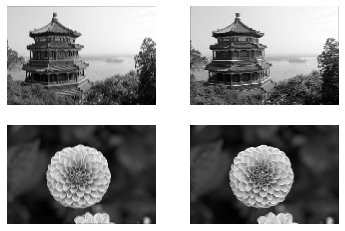

In [4]:
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(outputs[image_index, :, :, feature_map_index])

plt.show()

In [5]:
def crop(images):
    return images[150:220, 130:250]

Zapisywanie rysunku r_14_1_a


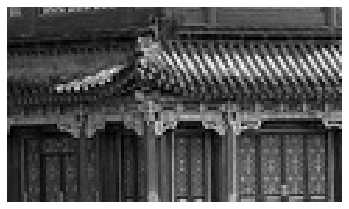

Zapisywanie rysunku r_14_1_b


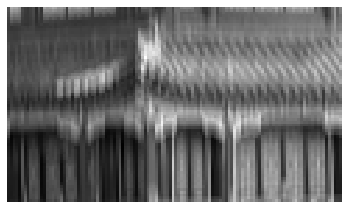

Zapisywanie rysunku r_14_1_c


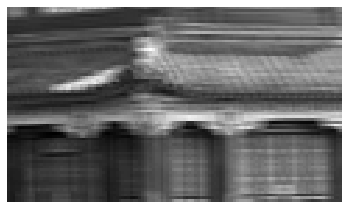

In [6]:
plot_image(crop(images[0, :, :, 0]))
save_fig("r_14_1_a", tight_layout=False)
plt.show()

for feature_map_index, filename in enumerate(["r_14_1_b", "r_14_1_c"]):
    plot_image(crop(outputs[0, :, :, feature_map_index]))
    save_fig(filename, tight_layout=False)
    plt.show()

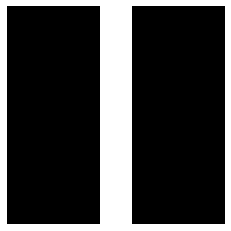

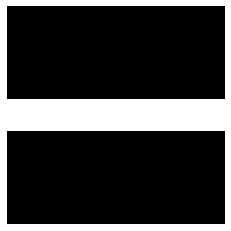

In [7]:
plot_image(filters[:, :, 0, 0])
plt.show()
plot_image(filters[:, :, 0, 1])
plt.show()

## Warstwa splotowa

Za pomocą funkcji `keras.layers.Conv2D()`:

In [8]:
conv = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1,
                           padding="SAME", activation="relu")

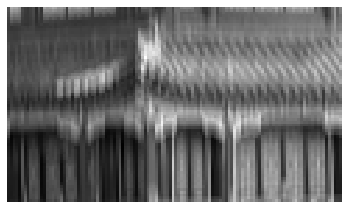

In [9]:
plot_image(crop(outputs[0, :, :, 0]))
plt.show()

## Uzupełnianie zerami typu VALID i SAME

In [10]:
def feature_map_size(input_size, kernel_size, strides=1, padding="SAME"):
    if padding == "SAME":
        return (input_size - 1) // strides + 1
    else:
        return (input_size - kernel_size) // strides + 1

In [11]:
def pad_before_and_padded_size(input_size, kernel_size, strides=1):
    fmap_size = feature_map_size(input_size, kernel_size, strides)
    padded_size = max((fmap_size - 1) * strides + kernel_size, input_size)
    pad_before = (padded_size - input_size) // 2
    return pad_before, padded_size

In [12]:
def manual_same_padding(images, kernel_size, strides=1):
    if kernel_size == 1:
        return images.astype(np.float32)
    batch_size, height, width, channels = images.shape
    top_pad, padded_height = pad_before_and_padded_size(height, kernel_size, strides)
    left_pad, padded_width  = pad_before_and_padded_size(width, kernel_size, strides)
    padded_shape = [batch_size, padded_height, padded_width, channels]
    padded_images = np.zeros(padded_shape, dtype=np.float32)
    padded_images[:, top_pad:height+top_pad, left_pad:width+left_pad, :] = images
    return padded_images

Uzupełnianie zerami typu `"SAME"` jest równoważne uzupełnianiu ręcznemu za pomocą funkcji `manual_same_padding()`, a następnie uzupełniania typu `"VALID"` (żeby było weselej, uzupełnianie typu `"VALID"` oznacza brak uzupełniania zerami):

In [13]:
kernel_size = 7
strides = 2

conv_valid = keras.layers.Conv2D(filters=1, kernel_size=kernel_size, strides=strides, padding="VALID")
conv_same = keras.layers.Conv2D(filters=1, kernel_size=kernel_size, strides=strides, padding="SAME")

valid_output = conv_valid(manual_same_padding(images, kernel_size, strides))

# Należy wywołać build(), aby zostały utworzone wagi warstwy conv_same
conv_same.build(tf.TensorShape(images.shape))

# Kopiuje wagi z warstwy conv_valid do warstwy conv_same
conv_same.set_weights(conv_valid.get_weights())

same_output = conv_same(images.astype(np.float32))

assert np.allclose(valid_output.numpy(), same_output.numpy())

# Warstwa łącząca

## Maksymalizująca warstwa łącząca

In [14]:
max_pool = keras.layers.MaxPool2D(pool_size=2)

In [15]:
cropped_images = np.array([crop(image) for image in images])
output = max_pool(cropped_images)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



Zapisywanie rysunku maks_warstwa_laczaca


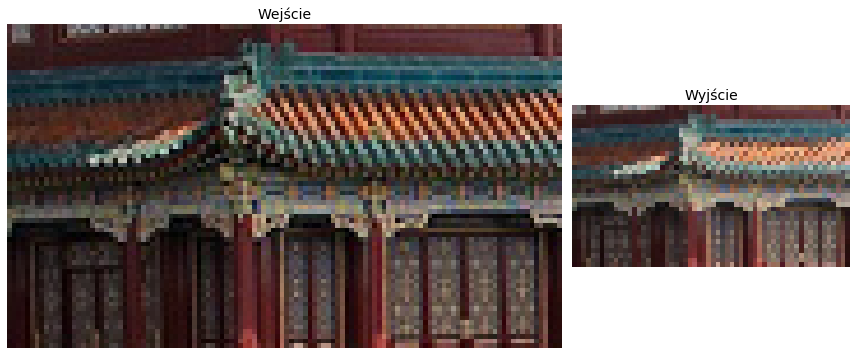

In [16]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Wejście", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Wyjście", fontsize=14)
ax2.imshow(output[0])  # plot the output for the 1st image
ax2.axis("off")
save_fig("maks_warstwa_laczaca")
plt.show()

## Głębokościowa warstwa łącząca

In [17]:
class DepthMaxPool(keras.layers.Layer):
    def __init__(self, pool_size, strides=None, padding="VALID", **kwargs):
        super().__init__(**kwargs)
        if strides is None:
            strides = pool_size
        self.pool_size = pool_size
        self.strides = strides
        self.padding = padding
    def call(self, inputs):
        return tf.nn.max_pool(inputs,
                              ksize=(1, 1, 1, self.pool_size),
                              strides=(1, 1, 1, self.pool_size),
                              padding=self.padding)

In [18]:
depth_pool = DepthMaxPool(3)
with tf.device("/cpu:0"): # nie istnieje jeszcze jądro GPU
    depth_output = depth_pool(cropped_images)
depth_output.shape


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



TensorShape([2, 70, 120, 1])

Lub można po prostu użyć warstwy `Lambda`:

In [19]:
depth_pool = keras.layers.Lambda(lambda X: tf.nn.max_pool(
    X, ksize=(1, 1, 1, 3), strides=(1, 1, 1, 3), padding="VALID"))
with tf.device("/cpu:0"): # nie istnieje jeszcze jądro GPU
    depth_output = depth_pool(cropped_images)
depth_output.shape


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



TensorShape([2, 70, 120, 1])

In [20]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("Wejście", fontsize=14)
plot_color_image(cropped_images[0])  # plot the 1st image
plt.subplot(1, 2, 2)
plt.title("Wyjście", fontsize=14)
plot_image(depth_output[0, ..., 0])  # plot the output for the 1st image
plt.axis("off")
plt.show()

## Uśredniająca warstwa łącząca

In [21]:
avg_pool = keras.layers.AvgPool2D(pool_size=2)

In [22]:
output_avg = avg_pool(cropped_images)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [23]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Wejście", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Wyjście", fontsize=14)
ax2.imshow(output_avg[0])  # plot the output for the 1st image
ax2.axis("off")
plt.show()

## Globalna uśredniająca warstwa łącząca

In [24]:
global_avg_pool = keras.layers.GlobalAvgPool2D()
global_avg_pool(cropped_images)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



<tf.Tensor: id=135, shape=(2, 3), dtype=float32, numpy=
array([[0.2788801 , 0.22507527, 0.20967631],
       [0.51287866, 0.4595188 , 0.3342377 ]], dtype=float32)>

In [25]:
output_global_avg2 = keras.layers.Lambda(lambda X: tf.reduce_mean(X, axis=[1, 2]))
output_global_avg2(cropped_images)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



<tf.Tensor: id=139, shape=(2, 3), dtype=float32, numpy=
array([[0.2788801 , 0.22507527, 0.20967631],
       [0.51287866, 0.4595188 , 0.3342377 ]], dtype=float32)>

# Przetwarzanie zestawu danych Fashion MNIST za pomocą sieci splotowej

In [26]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [27]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])

In [28]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=[X_valid, y_valid])
score = model.evaluate(X_test, y_test)
X_new = X_test[:10] # udajemy, że mamy nowe obrazy
y_pred = model.predict(X_new)

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 253s 5ms/sample - loss: 0.7019 - accuracy: 0.7544 - val_loss: 0.3638 - val_accuracy: 0.8662
Epoch 2/10
55000/55000 [==============================] - 263s 5ms/sample - loss: 0.4250 - accuracy: 0.8574 - val_loss: 0.3507 - val_accuracy: 0.8756
Epoch 3/10
55000/55000 [==============================] - 266s 5ms/sample - loss: 0.3689 - accuracy: 0.8753 - val_loss: 0.3043 - val_accuracy: 0.8914
Epoch 4/10
55000/55000 [==============================] - 264s 5ms/sample - loss: 0.3321 - accuracy: 0.8873 - val_loss: 0.2854 - val_accuracy: 0.8952
Epoch 5/10
55000/55000 [==============================] - 264s 5ms/sample - loss: 0.3151 - accuracy: 0.8932 - val_loss: 0.2986 - val_accuracy: 0.8920
Epoch 6/10
55000/55000 [==============================] - 262s 5ms/sample - loss: 0.2975 - accuracy: 0.8999 - val_loss: 0.2799 - val_accuracy: 0.8974
Epoch 7/10
55000/55000 [===========================

## ResNet-34

In [29]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [30]:
model = keras.models.Sequential()
model.add(DefaultConv2D(64, kernel_size=7, strides=2,
                        input_shape=[224, 224, 3]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

In [31]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 112, 112, 64)      9408      
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
residual_unit (ResidualUnit) (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_1 (ResidualUni (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_2 (ResidualUni (None, 56, 56, 64)       

## Korzystanie z gotowego modelu

In [32]:
model = keras.applications.resnet50.ResNet50(weights="imagenet")

102973440/102967424 [==============================] - 227s 2us/step


In [33]:
images_resized = tf.image.resize(images, [224, 224])
plot_color_image(images_resized[0])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


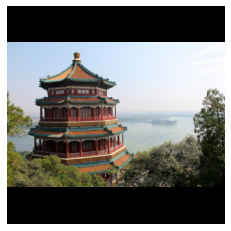

In [34]:
images_resized = tf.image.resize_with_pad(images, 224, 224, antialias=True)
plot_color_image(images_resized[0])

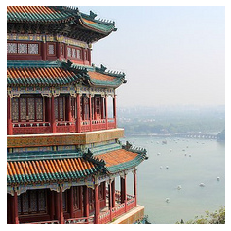

In [35]:
images_resized = tf.image.resize_with_crop_or_pad(images, 224, 224)
plot_color_image(images_resized[0])
plt.show()

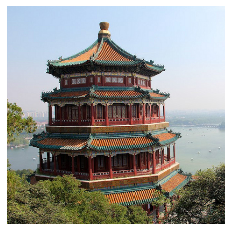

In [36]:
china_box = [0, 0.03, 1, 0.68]
flower_box = [0.19, 0.26, 0.86, 0.7]
images_resized = tf.image.crop_and_resize(images, [china_box, flower_box], [0, 1], [224, 224])
plot_color_image(images_resized[0])
plt.show()
plot_color_image(images_resized[1])
plt.show()

In [37]:
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)
Y_proba = model.predict(inputs)

In [38]:
Y_proba.shape

(2, 1000)

In [39]:
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    print("Obraz numer {}".format(image_index))
    for class_id, name, y_proba in top_K[image_index]:
        print("  {} - {:12s} {:.2f}%".format(class_id, name, y_proba * 100))
    print()

40960/35363 [==================================] - 0s 0us/step
Obraz numer 0
  n03877845 - palace       43.39%
  n02825657 - bell_cote    43.07%
  n03781244 - monastery    11.70%

Obraz numer 1
  n04522168 - vase         53.96%
  n07930864 - cup          9.52%
  n11939491 - daisy        4.97%



## Gotowe modele w uczeniu transferowym

In [40]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)

In [41]:
info.splits

{'train': <tfds.core.SplitInfo num_examples=3670>}

In [42]:
info.splits["train"]

<tfds.core.SplitInfo num_examples=3670>

In [43]:
class_names = info.features["label"].names
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [44]:
n_classes = info.features["label"].num_classes

In [45]:
dataset_size = info.splits["train"].num_examples
dataset_size

3670

In [46]:
test_split, valid_split, train_split = tfds.Split.TRAIN.subsplit([10, 15, 75])

test_set_raw = tfds.load("tf_flowers", split=test_split, as_supervised=True)
valid_set_raw = tfds.load("tf_flowers", split=valid_split, as_supervised=True)
train_set_raw = tfds.load("tf_flowers", split=train_split, as_supervised=True)

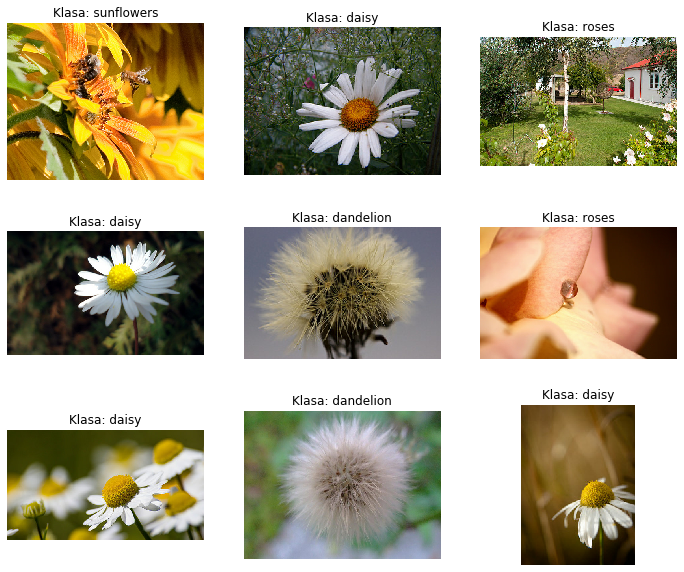

In [47]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Klasa: {}".format(class_names[label]))
    plt.axis("off")

plt.show()

Podstawowe przetwarzanie wstępne:

In [48]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

Nieco bardziej zaawansowane przetwarzanie wstępne (ale możesz dodać znacznie więcej w celu dogenerowania danych):

In [49]:
def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

In [50]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in train_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Klasa: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

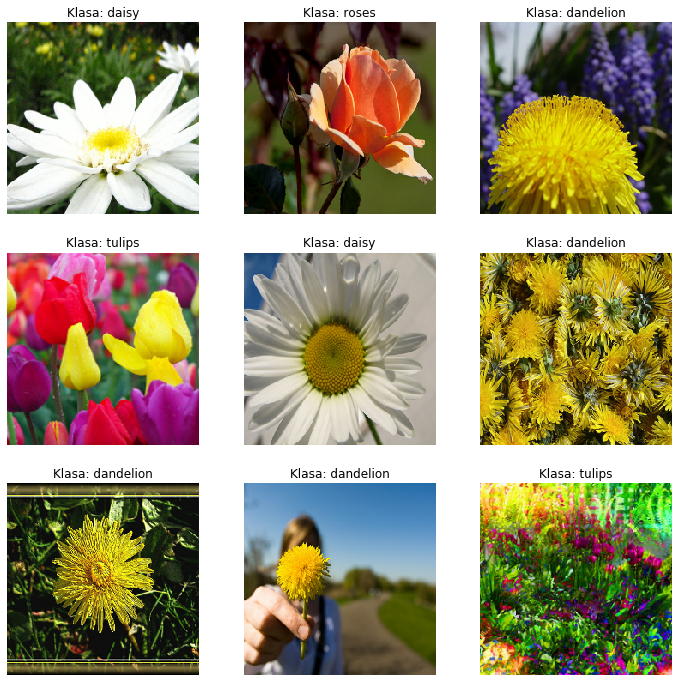

In [51]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in test_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Klasa: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

In [52]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

83689472/83683744 [==============================] - 151s 2us/step


In [53]:
for index, layer in enumerate(base_model.layers):
    print(index, layer.name)

0 input_2
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d_44
13 block2_pool
14 batch_normalization_36
15 add
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_45
23 block3_pool
24 batch_normalization_37
25 add_1
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_46
33 block4_pool
34 batch_normalization_38
35 add_2
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_3
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block6_se

In [54]:
for layer in base_model.layers:
    layer.trainable = False

optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=5)

Train for 86 steps, validate for 17 steps
Epoch 1/5
86/86 [==============================] - 313s 4s/step - loss: 0.7845 - accuracy: 0.7664 - val_loss: 2.5268 - val_accuracy: 0.6544
Epoch 2/5
86/86 [==============================] - 305s 4s/step - loss: 0.4326 - accuracy: 0.8634 - val_loss: 1.6453 - val_accuracy: 0.7132
Epoch 3/5
86/86 [==============================] - 308s 4s/step - loss: 0.3422 - accuracy: 0.8852 - val_loss: 1.9770 - val_accuracy: 0.6930
Epoch 4/5
86/86 [==============================] - 315s 4s/step - loss: 0.2754 - accuracy: 0.9132 - val_loss: 1.4481 - val_accuracy: 0.7353
Epoch 5/5
86/86 [==============================] - 304s 4s/step - loss: 0.2513 - accuracy: 0.9179 - val_loss: 1.3261 - val_accuracy: 0.7500


In [55]:
for layer in base_model.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=40)

Epoch 1/40
86/86 [==============================] - 172s 2s/step - loss: 0.2257 - accuracy: 0.9288 - val_loss: 0.6762 - val_accuracy: 0.8346
Epoch 2/40
86/86 [==============================] - 128s 1s/step - loss: 0.1124 - accuracy: 0.9640 - val_loss: 0.3932 - val_accuracy: 0.9154
Epoch 3/40
86/86 [==============================] - 129s 1s/step - loss: 0.0497 - accuracy: 0.9829 - val_loss: 0.2618 - val_accuracy: 0.9246
Epoch 4/40
86/86 [==============================] - 128s 1s/step - loss: 0.0425 - accuracy: 0.9836 - val_loss: 0.3446 - val_accuracy: 0.9136
Epoch 5/40
86/86 [==============================] - 128s 1s/step - loss: 0.0251 - accuracy: 0.9909 - val_loss: 0.2486 - val_accuracy: 0.9338
Epoch 6/40
86/86 [==============================] - 127s 1s/step - loss: 0.0142 - accuracy: 0.9949 - val_loss: 0.2324 - val_accuracy: 0.9430
Epoch 7/40
86/86 [==============================] - 128s 1s/step - loss: 0.0195 - accuracy: 0.9945 - val_loss: 0.2785 - val_accuracy: 0.9357
Epoch 8/40
86

# Klasyfikowanie i lokalizowanie

In [55]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = keras.layers.Dense(n_classes, activation="softmax")(avg)
loc_output = keras.layers.Dense(4)(avg)
model = keras.models.Model(inputs=base_model.input,
                           outputs=[class_output, loc_output])
model.compile(loss=["sparse_categorical_crossentropy", "mse"],
              loss_weights=[0.8, 0.2], # w zależności od tego, na czym najbardziej Ci zależy
              optimizer=optimizer, metrics=["accuracy"])

In [56]:
def add_random_bounding_boxes(images, labels):
    fake_bboxes = tf.random.uniform([tf.shape(images)[0], 4])
    return images, (labels, fake_bboxes)

fake_train_set = train_set.take(5).repeat(2).map(add_random_bounding_boxes)

In [ ]:
model.fit(fake_train_set, steps_per_epoch=5, epochs=2)

Train for 5 steps
Epoch 1/2
4/5 [=======================>......] - ETA: 2:18 - loss: 1.3350 - dense_5_loss: 1.5874 - dense_6_loss: 0.3255 - dense_5_accuracy: 0.2891 - dense_6_accuracy: 0.1875

### Średnia wartość przeciętna precyzji (mAP)

In [59]:
def maximum_precisions(precisions):
    return np.flip(np.maximum.accumulate(np.flip(precisions)))

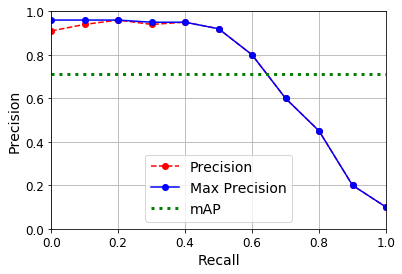

In [60]:
recalls = np.linspace(0, 1, 11)

precisions = [0.91, 0.94, 0.96, 0.94, 0.95, 0.92, 0.80, 0.60, 0.45, 0.20, 0.10]
max_precisions = maximum_precisions(precisions)
mAP = max_precisions.mean()
plt.plot(recalls, precisions, "ro--", label="Precyzja")
plt.plot(recalls, max_precisions, "bo-", label="Maksymalna precyzja")
plt.xlabel("Pełność")
plt.ylabel("Precyzja")
plt.plot([0, 1], [mAP, mAP], "g:", linewidth=3, label="mAP")
plt.grid(True)
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower center", fontsize=14)
plt.show()

Transponowane operacje splotu:

In [61]:
tf.random.set_seed(42)
X = images_resized.numpy()

conv_transpose = keras.layers.Conv2DTranspose(filters=5, kernel_size=3, strides=2, padding="VALID")
output = conv_transpose(X)
output.shape

TensorShape([2, 449, 449, 5])

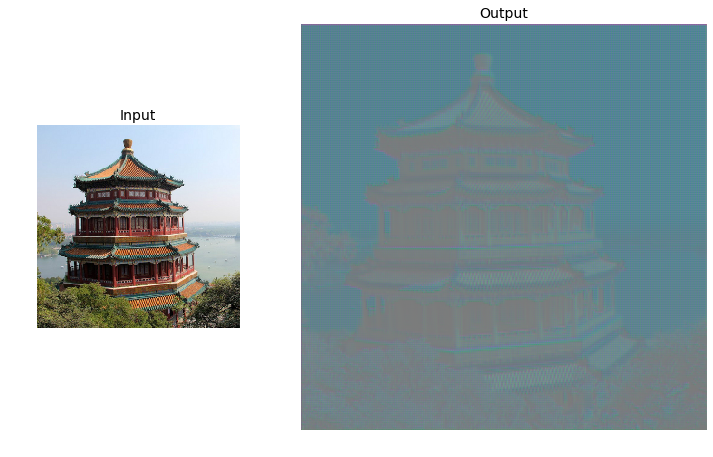

In [62]:
def normalize(X):
    return (X - tf.reduce_min(X)) / (tf.reduce_max(X) - tf.reduce_min(X))

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[1, 2])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Wejście", fontsize=14)
ax1.imshow(X[0])  # wyświetla pierwszy obraz
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Wyjście", fontsize=14)
ax2.imshow(normalize(output[0, ..., :3]), interpolation="bicubic")  # wyświetla rezultat uzyskany z pierwszego obrazu
ax2.axis("off")
plt.show()

In [63]:
def upscale_images(images, stride, kernel_size):
    batch_size, height, width, channels = images.shape
    upscaled = np.zeros((batch_size,
                         (height - 1) * stride + 2 * kernel_size - 1,
                         (width - 1) * stride + 2 * kernel_size - 1,
                         channels))
    upscaled[:,
             kernel_size - 1:(height - 1) * stride + kernel_size:stride,
             kernel_size - 1:(width - 1) * stride + kernel_size:stride,
             :] = images
    return upscaled

In [64]:
upscaled = upscale_images(X, stride=2, kernel_size=3)
weights, biases = conv_transpose.weights
reversed_filters = np.flip(weights.numpy(), axis=[0, 1])
reversed_filters = np.transpose(reversed_filters, [0, 1, 3, 2])
manual_output = tf.nn.conv2d(upscaled, reversed_filters, strides=1, padding="VALID")

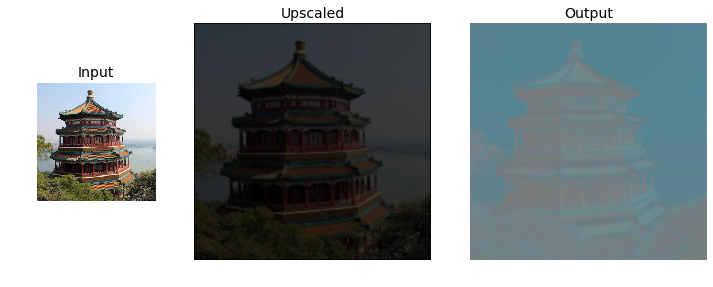

In [65]:
def normalize(X):
    return (X - tf.reduce_min(X)) / (tf.reduce_max(X) - tf.reduce_min(X))

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=3, width_ratios=[1, 2, 2])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Wejście", fontsize=14)
ax1.imshow(X[0])  # wyświetla pierwszy obraz
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Powiększony", fontsize=14)
ax2.imshow(upscaled[0], interpolation="bicubic")
ax2.axis("off")
ax3 = fig.add_subplot(gs[0, 2])
ax3.set_title("Wyjście", fontsize=14)
ax3.imshow(normalize(manual_output[0, ..., :3]), interpolation="bicubic")  # wyświetla rezultat uzyskany z pierwszego obrazu
ax3.axis("off")
plt.show()

In [66]:
np.allclose(output, manual_output.numpy(), atol=1e-7)

True

# Ćwiczenia

## 1. do 8.

Zobacz dodatek A.

## 9. Sieć splotowa dużej dokładności dla zbioru MNIST
Ćwiczenie: Stwórz własną sieć CNN i spróbuj osiągnąć jak największą dokładność dla zestawu danych MNIST.

## 10.  Skorzystaj z uczenia transferowego w klasyfikowaniu dużych obrazów

### 10.1)
Stwórz zbiór uczący składający się przynajmniej ze 100 obrazów na każdą klasę. Przykładowo, możesz klasyfikować własne zdjęcie pod względem lokalizacji (plaża, góry, miasto itd.) lub ewentualnie skorzystać z istniejącego zbioru danych (np. z projektu TensorFlow Datasets).

### 10.2)
Podziel zestaw danych na zbiór uczący, walidacyjny i testowy.

### 10.3)
Zbuduj potok danych wejściowych, zawierający odpowiednie operacje przetwarzania wstępnego, a także dodatkowo operacje dogenerowania danych.

### 10.4)
Dostosuj gotowy model do tego zestawu danych.

## 11.
Ćwiczenie: Zapoznaj się z [samouczkiem DeepDream](https://goo.gl/4b2s6g). Jest to interesujący sposób przyswojenia wiedzy na temat wizualizowania wzorców wykrywanych przez sieć splotową, a także generowania sztuki za pomocą uczenia głębokiego.


Wystarczy pobrać notatnik i wykonywać zawarte w nim instrukcje. Dodatkowo możesz wygenerować szereg obrazów poprzez ciągłe powiększanie ich i uruchamianie algorytmu DeepDream: możesz stworzyć filmik z tych obrazów za pomocą takiego narzędzia, jak [ffmpeg](https://ffmpeg.org/). Spójrz, na przykład, na stworzony przeze mnie [filmik](https://www.youtube.com/watch?v=l6i_fDg30p0)... Jak się przekonasz, dość szybko zmienia się w koszmar ;-) W internecie znajdziesz setki [podobnych filmików](https://www.youtube.com/results?search_query=+deepdream) (często mających znacznie większe walory artystyczne).